### Assess model performance post-training

#### Parameters

In [1]:
import os

config = '/home/Thomas/ABC_expeditions_classifier/configs/exp_resnet18.yaml'
split = 'test' # options are "train", "test", and "none"
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [3]:
import torch
import pandas as pd

import yaml

from ct_classifier.train import create_dataloader
from ct_classifier.dataset import CTDataset
from ct_classifier.model import CustomResNet18

cfg = yaml.safe_load(open(config, 'r'))
checkpoint_path="/home/Thomas/ABC_expeditions_classifier/ct_classifier/model_states/200.pt"

# 1. Loading the model

device = cfg['device']

model = CustomResNet18(cfg['num_classes'])

# 2. Grab the latest model (if pre-trained model exists)

state = torch.load(open(checkpoint_path, 'rb'), map_location=device)
model.load_state_dict(state['model'])
model.to(device)
model.eval()

# 3. Prepare the data loader

dl_val = create_dataloader(cfg, split='test')

batch = next(iter(dl_val))



/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_598534/3704398385.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (

In [4]:
from torch.nn import Softmax
import numpy as np

prediction_labels = []
prediction_confs = []
true_labels = []
file_list = []
prediction_df_raw = []

label_dict = dl_val.dataset.inv_labels

for idx, (data, labels, file_names) in enumerate(dl_val):
  
  data = data.to(device)
  
  # Predict labels on validation data
  
  s = Softmax(dim=1)
  
  with torch.no_grad():
    prediction = model(data)
  
  prediction_raw = prediction # no softmax applied
  prediction_raw = prediction_raw.cpu().numpy()
  prediction_raw = pd.DataFrame(prediction_raw, columns=range(prediction_raw.shape[1]))

  prediction = s(prediction) # softmax applied

  pred_label = torch.argmax(prediction, dim=1)
  pred_label_conv = [label_dict[int(x.item())] for x in pred_label]
  pred_conf = prediction.max(dim = 1).values

  # Prepare dataframe 1
  prediction_raw.insert(0, "predicted_label", np.array(pred_label.cpu()))
  prediction_raw.insert(0, 'file_name', file_names)
  
  prediction_labels.append(pred_label.cpu().numpy())
  prediction_confs.append(pred_conf.cpu().numpy())
  
  # Get ground-truth labels 
  labels_conv = [label_dict[int(x.item())] for x in labels]
  true_labels.append(labels)
  file_list.append(file_names)

  prediction_df_raw.append(prediction_raw)

prediction_df_raw = pd.concat(prediction_df_raw, ignore_index=True)

prediction_df = {'pred_labels': np.hstack(prediction_labels),
                 "pred_confs" : np.hstack(prediction_confs), 
                 "true_labels": np.hstack(true_labels), 
                 "file_names": np.hstack(file_list)}
    
prediction_df = pd.DataFrame(prediction_df)

['file_name', 'predicted_label', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [6]:
import numpy as np

prediction_df.file_names.value_counts()

file_names
fb14f0c3-a476-46c4-b43b-3e563f994521_frame73_detection0     1
bbc97596-e036-4aca-8d7f-f20c88da022f_frame81_detection0     1
0bea4c33-ad2c-4349-a5d6-7a49d2faaa9d_frame54_detection0     1
43cdf13a-8c35-4f76-b069-f9b2901c8a16_frame83_detection0     1
a4a5bcd4-2a80-469d-9a0c-f68b4b8bf373_frame54_detection0     1
                                                           ..
16658dda-3ac0-452a-9994-1de24abc7054_frame0_detection0      1
7d149cd3-5032-4745-a217-83e189e94205_frame57_detection1     1
d367cd53-1fb0-4a9a-9597-d624c2a75d0b_frame14_detection0     1
c8ef7152-bfc1-4f04-8c72-fb07309aa3c9_frame71_detection0     1
4a5072a8-9c3f-444f-b2e0-615164af7dc8_frame104_detection1    1
Name: count, Length: 9100, dtype: int64

In [7]:
len(prediction_df)

9100

In [7]:
import yaml
from ct_classifier.train import create_dataloader

cfg = yaml.safe_load(open(config, 'r'))

dl_test = create_dataloader(cfg = cfg, split=split)

batch = next(iter(dl_test))



In [2]:
from ct_classifier.inference import model_inference

df_summary, df_raw = model_inference(config=config, checkpoint_path="/home/Thomas/ABC_expeditions_classifier/ct_classifier/model_states/200.pt")

/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/Thomas/miniconda3/envs/ABC_expeditions_classifier/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/Thomas/ABC_expeditions_classifier/ct_classifier/inference.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arb

In [8]:
# Save the raw prediction scores for each sample as a csv

import os

target_folder = os.path.join(parent_dir, "posthoc_data")
target_filename = "raw_prediction_scores_val.csv"
target_path = os.path.join(target_folder, target_filename)
df_raw.to_csv(target_path, index=False, )


#### Make a confusion matrix

In [13]:
cmn[6]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

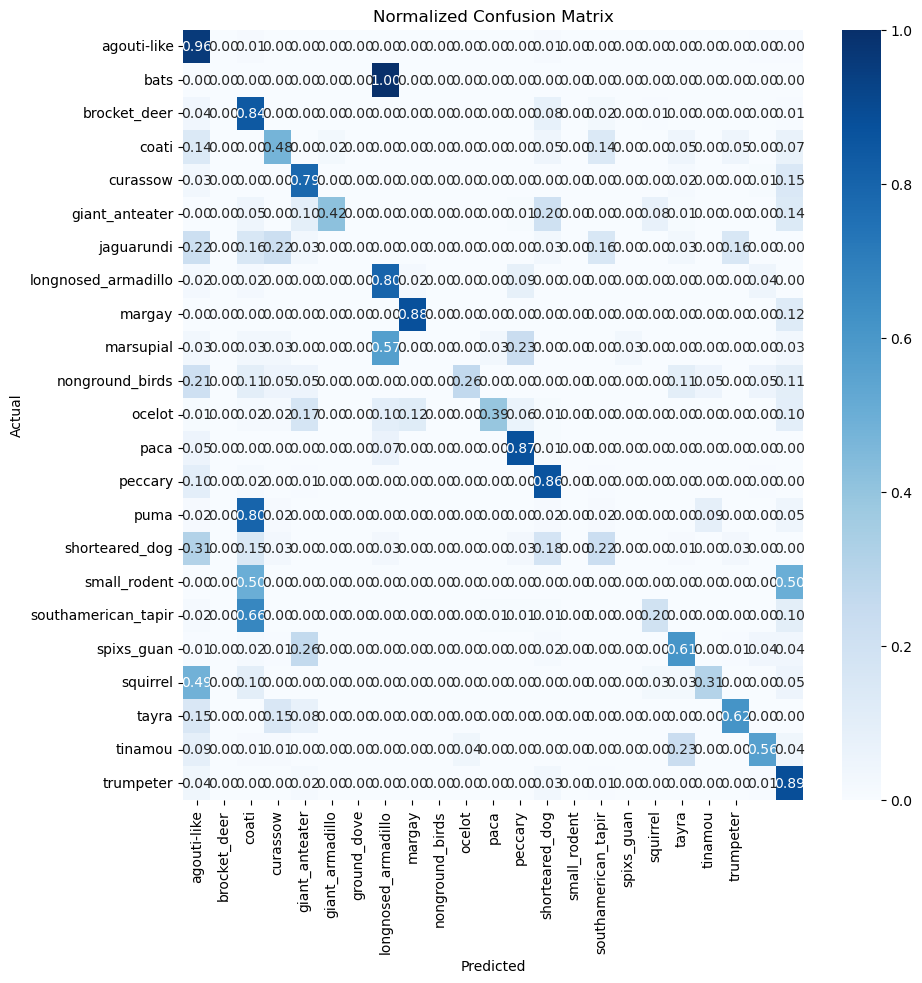

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


# Assuming df_summary["true_labels_full"] and df_summary["pred_labels_full"] are pandas Series with categorical labels
true_labels = df_summary["true_labels_full"].unique()
pred_labels = df_summary["pred_labels_full"].unique()

# Ensure labels are in sorted order for consistent mapping (optional, depends on your use case)
true_labels = np.sort(true_labels)
pred_labels = np.sort(pred_labels)

cm = confusion_matrix(df_summary["true_labels_full"], 
                      df_summary["pred_labels_full"], 
                      labels=true_labels,  # Ensures consistent label ordering
                      normalize="true")

# Plot with labels
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=pred_labels, yticklabels=true_labels, cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Normalized Confusion Matrix')
plt.show()